# Boat Listings Newsletter

Import libraries

In [1]:
! pip install geopy

     |████████████████████████████████| 118 kB 27.3 MB/s            


In [127]:
!pip install squarify

  Using cached squarify-0.4.3-py3-none-any.whl (4.3 kB)


In [128]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import seaborn as sns

import squarify
import matplotlib

## Business Problem
We are developing a weekly newsletter to help sellers get more views on their boats and track market trends.

We want to know which features popular boats have in common, and in specific if expensive boats are more popular.

## Data 

The dataset is saved in the file 'boat_data.csv'.

We will assess the dataset to identify possible issues and cleaning procedure.

In [3]:
df = pd.read_csv("boat_data.csv", encoding = 'utf-8')
df.head(5)

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days
0,CHF 3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland Â» Lake Geneva Â» VÃ©senaz,226
1,EUR 3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75
2,CHF 3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124
3,DKK 25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark Â» Svendborg,64
4,EUR 3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58


The first 5 rows indicate that the following tasks must be accomplished before analysis:
- Price must be converted to the same currency. We will use euros. Its datatype should also be numeric.
- The value 0 in Year Built must be assumed as missing data
- Location is ill-formatted. For this analysis, we will only extract countries.

Other problems may also exist further down in the dataset.

In [4]:
print(df.shape)
df.info()

(9888, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        9888 non-null   object 
 1   Boat Type                    9888 non-null   object 
 2   Manufacturer                 8550 non-null   object 
 3   Type                         9882 non-null   object 
 4   Year Built                   9888 non-null   int64  
 5   Length                       9879 non-null   float64
 6   Width                        9832 non-null   float64
 7   Material                     8139 non-null   object 
 8   Location                     9852 non-null   object 
 9   Number of views last 7 days  9888 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 772.6+ KB


We see that the dataset has 9888 rows and 10 columns. Columns Manufacturer, Type, Length, Width, Material and Location have missing data. As with Year Built there may be other columns with entries equivalent to missing data.

As for datatypes, only Price needs to be changed. Let's start from there, so that we can later examine its and the other numerical variables distribution. For categorical variables, we will check their unique values.

### Correct datatype (Price)

In [5]:
price_tmp = df["Price"].str.split(" ", expand=True)

print(price_tmp[0].unique())

CHF_to_EUR = 0.96
DKK_to_EUR = 0.13
GBP_to_EUR = 1.18

price_tmp[1] = pd.to_numeric(price_tmp[1])

price_tmp[1] = np.where(price_tmp[0] == "CHF", CHF_to_EUR*price_tmp[1], price_tmp[1])
price_tmp[1] = np.where(price_tmp[0] == "DKK", DKK_to_EUR*price_tmp[1], price_tmp[1])
price_tmp[1] = np.where(price_tmp[0] == "GBP", GBP_to_EUR*price_tmp[1], price_tmp[1])

df["Price"] = price_tmp[1]

['CHF' 'EUR' 'DKK' 'Â£']


### Distribution of numerical variables

We will check the distribution of the numerical variables. We will also take this opportunity to make sure that all nulls are of the type np.nan (a float).

In [6]:
cols = df.select_dtypes(include=np.number).columns
df[cols] = np.where(df[cols].isnull(), np.nan, df[cols])

In [7]:
df.describe()

,Price,Year Built,Length,Width,Number of views last 7 days
count,9.888000e+03,9888.000000,9879.000000,9832.000000,9888.000000
mean,2.987561e+05,1893.192860,11.570017,3.520124,149.160801
std,9.588034e+05,460.201582,6.002820,1.220534,151.819752
min,3.203520e+03,0.000000,1.040000,0.010000,13.000000
25%,4.275750e+04,1996.000000,7.470000,2.540000,70.000000
50%,9.130750e+04,2007.000000,10.280000,3.330000,108.000000
75%,2.450000e+05,2017.000000,13.930000,4.250000,172.000000
max,3.100000e+07,2021.000000,100.000000,25.160000,3263.000000


Year Built is the only one with equivalent to missing data. Lets see that distribution. 

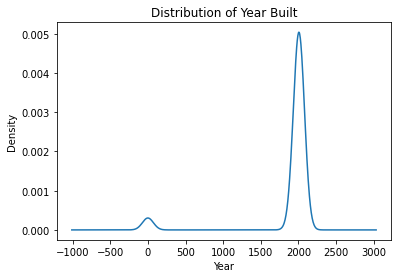

In [8]:
df["Year Built"].plot.kde(title="Distribution of Year Built")
plt.xlabel("Year")
plt.show()

It seems that the the data is either zero or larger than 1700. But to be on the safe side, we will assume that any date before 500 is missing data.

In [9]:
df["Year Built"] = np.where(df["Year Built"] < 500, np.nan, df["Year Built"])

### Distribution of categorical variables

We will start by checking the unique values of each variable. We will probably not plot them in an histogram or as treemaps because there wiil probably have too many unique values.

Similar to the numericalvariables, we will replace all nulls with None.

In [10]:
cols = df.select_dtypes(include=object).columns
df[cols] = np.where(df[cols].isnull(), None, df[cols])

In [11]:
for col in df.select_dtypes(include=object).columns:
    print("{} ({}): {}\n".format(col, len(df[col].unique()), df[col].unique()))

Boat Type (126): ['Motor Yacht' 'Center console boat' 'Sport Boat' 'Fishing Boat'
 'Catamaran' 'Pontoon Boat' 'Runabout' 'Deck Boat' 'Pilothouse'
 'Cabin Boat' 'Working Boat' 'Classic' 'Bowrider'
 'Sport Boat,Working Boat' 'Cabin Boat,Classic'
 'Deck Boat,Pilothouse,Sport Boat' 'Trawler' 'Launch' 'Cabin Boat,Trawler'
 'Bowrider,Classic' 'Motor Yacht,Sport Boat' 'Classic,Runabout,Sport Boat'
 'Cabin Boat,Motor Yacht' 'Classic,Launch' 'Cabin Boat,Sport Boat'
 'Flybridge' 'Water ski' 'Hardtop' 'Classic,Runabout' 'Offshore Boat'
 'Cabin Boat,Sport Boat,Wakeboard/Wakesurf' 'Classic,Pontoon Boat'
 'Classic,Motor Yacht' 'Motor Yacht,Sport Boat,Trawler'
 'Wakeboard/Wakesurf' 'Passenger boat' 'Classic,Sport Boat,Water ski'
 'Classic,Sport Boat' 'House Boat' 'Classic,Motorsailer'
 'Sport Boat,Wakeboard/Wakesurf' 'Pilothouse,Sport Boat'
 'House Boat,Motor Yacht' 'Cabin Boat,Classic,Trawler'
 'Passenger boat,Working Boat' 'Wakeboard/Wakesurf,Water ski'
 'Classic,Motor Yacht,Passenger boat' 'Offsho

In Boat Type, we have multiple types in a single entry, e.e. 'Center console boat,Sport Boat,Water ski'. We need to separate these values, check again the number of unique values, while keeping note of the entries thay have these values. We will use one hot encoding.

In Manufacturer, it seems that all entries have 'power boats'. We can verify this and drop them. This will make our graphs more legible.

In Type, we have the same situation as in Boat Type and will proceed alike.

Material looks okay.

We will extract the country from Location, using " Â» " as separator and geopy.

In [12]:
def do_one_hot_enconding (df, col): 
    tmp = df[col].str.split(",", expand=True)
    cols = pd.unique(tmp.values.ravel('K'))  
    cols = np.delete(cols, np.where(cols == None))
    if col == "Boat Type":
        cols_names = ["Boat type_" + str(i) for i in cols]
    else:
        cols_names = [col + "_" + str(i) for i in cols]

    df_new = pd.DataFrame(data = np.zeros((len(df), len(cols)), 
                                            dtype=int), columns = cols_names)
    
    for entry, col_name in zip(cols, cols_names):
        ind_tmp = df[df[col].notnull() & df[col].str.contains(entry)].index
        df_new.loc[ind_tmp, col_name] = 1
        
    return df_new

In [13]:
df_boat_type = do_one_hot_enconding (df, 'Boat Type')
df_type = do_one_hot_enconding (df, 'Type')

In [14]:
print("Do all entries have the expression 'power boats' in the variable Manufacturer (except nulls)?")
print(len(df[df['Manufacturer'].notnull()]) == len(df[df['Manufacturer'].notnull() & 
                                              df['Manufacturer'].str.contains("power boats")]))

df['Manufacturer'] = df['Manufacturer'].replace({' power boats':''}, regex=True)

Do all entries have the expression 'power boats' in the variable Manufacturer (except nulls)?
True


In [15]:
df_countries = df["Location"].str.split(" Â» ", expand=True)[0]
print(df_countries.unique())

['Switzerland' 'Germany' 'Denmark' 'Italy' 'France' 'United Kingdom'
 'Spain' 'Austria' 'Netherlands' 'Slovenia' 'Serbia' 'Belgium'
 'Slovak Republic' 'Croatia (Hrvatska)' 'Portugal' 'Malta' 'Montenegro'
 'Latvia' 'Rovinij' 'Steinwiesen' 'Greece' 'Rolle' 'Poland' 'baden baden'
 'Donau' 'TravemÃ¼nde ' 'Lake Constance' 'Turkey' 'Stralsund ' 'Rostock '
 'Lake Geneva' 'Split' 'Finland' 'lago maggiore' 'BelgiÃ«, Zulte '
 'Niederrhein' 'Hungary' 'Brandenburg an derHavel' 'RÃ¼gen' 'Zevenbergen'
 'Oder' 'Cyprus' 'Faoug' 'Beilngries ' 'Czech Republic' 'Sweden'
 'Lithuania' 'United States' 'Marina Punat' 'Ukraine'
 'French Southern Territories' 'Italien ' 'Brandenburg ' None 'Estonia'
 'Monaco' 'Russian Federation' 'waren mÃ¼ritz ' 'Egypt' 'Jersey'
 'United Arab Emirates' 'Australia' 'Bulgaria' 'Philippines' 'Taiwan'
 'Thailand' 'Luxembourg' 'Venezuela' 'Neustadt in Holstein (Ostsee)'
 'Ireland' 'Adria' 'Martinique' 'Norway' 'Seychelles' 'Morocco'
 'Gibraltar' 'Lebanon' 'Ostsee' 'Mallorca ' 'Gre

### Creation of new variables country and continent

Some of these names are ilegible. Any name with special characters will be replace by None.

In [16]:
loc_tmp = df["Location"].str.split(" Â» ", expand=True)

geolocator = Nominatim(user_agent='test', timeout=300)
alphabet = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ, ()'
loc_tmp[loc_tmp[0].str.strip(alphabet).astype(bool) == True] = None
main_locations = loc_tmp[loc_tmp[0].str.strip(alphabet).astype(bool) == False][0].unique()

countries = {}
bad = []

for item in main_locations:
    loc = geolocator.geocode(item)
    if loc != None:
        rev = geolocator.reverse(loc.point, language="en")
        if rev != None:
            country = rev.raw["address"]["country"]
            countries[item] = country
    else:
        bad.append(item)
        countries[item] = None
        
loc_tmp[0] = loc_tmp[0].replace(to_replace=countries.keys(), value=countries.values())
    
df['Country'] = loc_tmp[0]

In [17]:
df["Country"].unique()

array(['Switzerland', 'Germany', 'Denmark', 'Italy', 'France',
       'United Kingdom', 'Spain', 'Austria', 'Netherlands', 'Slovenia',
       'Serbia', 'Belgium', 'Slovakia', 'Croatia', 'Portugal', 'Malta',
       'Montenegro', 'Latvia', None, 'Greece', 'Poland', 'Hungary',
       'Turkey', 'United States', 'Finland', 'Cyprus', 'Czechia',
       'Sweden', 'Lithuania', 'Ukraine', 'Estonia', 'Monaco', 'Russia',
       'Egypt', 'Jersey', 'United Arab Emirates', 'Australia', 'Bulgaria',
       'Philippines', 'Taiwan', 'Thailand', 'Luxembourg', 'Venezuela',
       'Ireland', 'Norway', 'Seychelles', 'Morocco', 'Gibraltar',
       'Lebanon', 'Ostsee', 'Isle of Man', 'Romania'], dtype=object)

We will also add continents.

In [18]:
df['Continent'] = ""

df['Continent'] = np.where(df['Country'].isin(['United Arab Emirates', 'Philippines', 'Taiwan', 
                                               'Thailand', 'Lebanon']), "Asia", "Europe")

df['Continent'] = np.where(df['Country'].isin(['Egypt', 'Morocco']), "Africa", df['Continent'])

df['Continent'] = np.where(df['Country'].isin(['United States', 'Venezuela']), "America", df['Continent'])

df['Continent'] = np.where(df['Country'].isin(['Australia']), "Oceania", df['Continent'])

df['Continent'] = np.where(df['Country'].isin([None]), None, df['Continent'])

We will do three final steps to complete the data cleaning phase:
- Join boat type and type dataframes with df
- Drop boat type and type 
- Save the cleaned data

### Save cleaned data
To save time, we can restart the notebook from here.

In [19]:
df = df[['Price', 'Manufacturer', 'Year Built', 'Length',
       'Width', 'Material', 'Country', 'Continent', 'Number of views last 7 days']]
df = df.join([df_boat_type, df_type])

df.to_csv("data_cleaned.csv")

## Methodology

We have access to the number of views of 9888 boat listings for the last 7
days.
We will select the boat listings that account for 10% (150 boat listings) of the
total number of views and analyze which features they have in common. We
will also compare how the selected listings compare with the others, e.g. in
terms of price.
We will provide the marketing team with the most common features of
popular boat listings, as well as identify the countries where we anticipate a
better reception of our newsletter.

In [141]:
new_df = pd.read_csv("data_cleaned.csv", index_col=0)
new_df.head()

,Price,Manufacturer,Year Built,Length,Width,Material,Country,Continent,Number of views last 7 days,Boat type_Motor Yacht,...,Type_new boat from stock,Type_Used boat,Type_new boat on order,Type_Unleaded,Type_Diesel,Type_Display Model,Type_Electric,Type_Gas,Type_Hybrid,Type_Propane
0,3203.52,Rigiflex,2017.0,4.00,1.90,NaN,Switzerland,Europe,226.0,1,...,1,0,0,0,0,0,0,0,0,0
1,3490.00,Terhi,2020.0,4.00,1.50,Thermoplastic,Germany,Europe,75.0,0,...,1,0,0,0,0,0,0,0,0,0
2,3619.20,Marine,NaN,3.69,1.42,Aluminium,Switzerland,Europe,124.0,0,...,1,0,0,0,0,0,0,0,0,0
3,3367.00,Pioner,2020.0,3.00,1.00,NaN,Denmark,Europe,64.0,0,...,1,0,0,0,0,0,0,0,0,0
4,3399.00,Linder,2019.0,3.55,1.46,Aluminium,Germany,Europe,58.0,0,...,1,0,0,0,0,0,0,0,0,0


### Creation of new variable price_rank

After a brief analysis (a few cells below), we decided to include price rank.

In [142]:
new_df['Price_rank'] = new_df['Price'].rank(method='dense')

### Selection of the boat listings that account for 10% of the views

In [143]:
new_df = new_df.sort_values("Number of views last 7 days", ascending=False)
new_df["views_cumsum"] = new_df["Number of views last 7 days"].cumsum()

new_df = new_df.reset_index()

idx = np.argmin(abs(new_df['views_cumsum'] - sum(new_df["Number of views last 7 days"])*0.1))

popular_df = new_df.loc[:149, :]

print("We selected {} boat listings.".format(len(popular_df)))

We selected 150 boat listings.


### Plots of numerical data

For the numerical data, stripplots are a good option. For coherence, we will keep the popular boat listings in orange and the rest as grey.

In [180]:
def do_stripplot(new_df, popular_df, col, title, xlabel):

    f = plt.figure(figsize=(8,4))

    ax = sns.stripplot(x=new_df[col], color="0.8", label="All listings", size=6)

    ax = sns.stripplot(x=popular_df[col], color="orange", label="Popular listings", size=6)

    sns.despine(bottom = True, left = True)

    plt.title(title, color="orange", fontweight="bold", fontsize=16)
    plt.legend(fontsize=13)

    ax.xaxis.labelpad = 2
    ax.set_xlabel(xlabel, fontsize=13)
    
    if col == 'Length':
        plt.xticks(np.arange(0, 104, 5))
        
    elif col == 'Width':
        plt.xticks(np.arange(0, 27, 2))
        
    f.tight_layout()
    
    plt.savefig("images/{}.png".format(col), transparent=True, dpi=120)

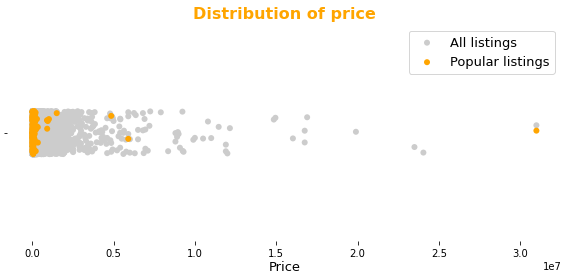

In [181]:
do_stripplot(new_df, popular_df, "Price", "Distribution of price", "Price")

This plot does not show any relevant information. Instead of price, we can use a price rank.
I will create it before creating popular_df, so that popular_df has that information.

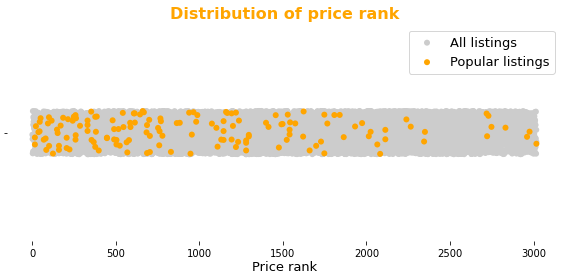

In [182]:
do_stripplot(new_df, popular_df, "Price_rank", "Distribution of price rank", "Price rank")

The 150 most popular listings are among the 1000th cheapest. This poses two questions:
- Exactly how many popular boats are among the 1000th cheapest boat listings?
- What is the price of the 1000th cheapest boat listings?
- Is there a direct connection?

86 out of the 150 most popular boat listings are among the 1000th cheapest (less than 48864).


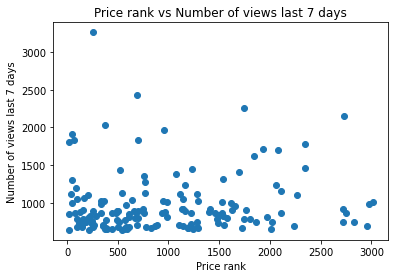

In [183]:
price_1000 = int(new_df[new_df['Price_rank'] == 1000]['Price'])

print("{} out of the 150 most popular boat listings are among the \
1000th cheapest (less than {}).".format(len(popular_df[popular_df['Price'] <= price_1000]),
                                       price_1000))

plt.scatter(popular_df['Price_rank'], popular_df['Number of views last 7 days'])
plt.title("Price rank vs Number of views last 7 days")
plt.xlabel("Price rank")
plt.ylabel("Number of views last 7 days")

plt.show()

There is not a direct connection. However, this is not a good plot for a presentation. This information is easier conveyed by a table.

In [184]:
popular_df[['Price_rank']].head(5).astype('int')

,Price_rank
0,259
1,687
2,1748
3,2730
4,377


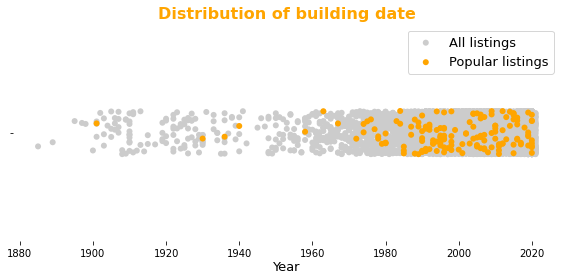

In [185]:
do_stripplot(new_df, popular_df, 'Year Built', "Distribution of building date", "Year")

The most popular listings have all been built during the 20th and 21st centuries, with most of them having been built after 1980.

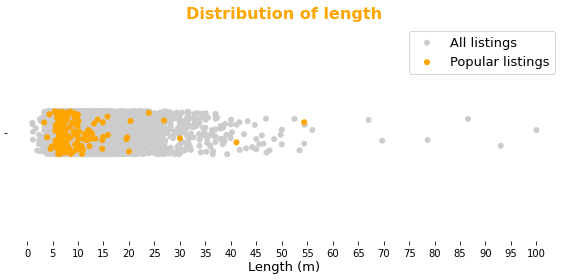

In [186]:
do_stripplot(new_df, popular_df, 'Length', "Distribution of length", "Length (m)")

Users search mostly boats with lengths between 5 and 15 metres.

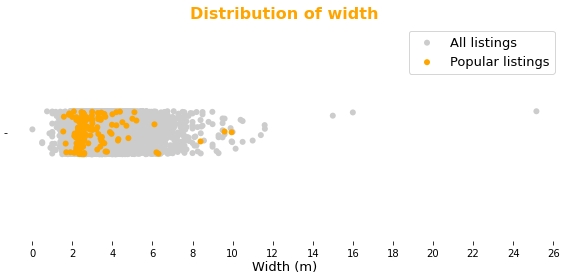

In [187]:
do_stripplot(new_df, popular_df, 'Width', "Distribution of width", "Width (m)")

Users search mostly boats with widths between 2 and 4 metres.

### Plots of categorical data

For the categorical variables, except location, bar plots will be used. 

For location, given that most places but not all are in Europe, a treemap is preferred.

For readability reasons, the barplots should not have more than 8 bars.

In [152]:
x1 = popular_df["Manufacturer"].value_counts()[popular_df["Manufacturer"].value_counts() > 3].sort_index() 
df_tmp = new_df.drop(popular_df.index)
df_tmp["Manufacturer"].value_counts()[df_tmp["Manufacturer"].value_counts().index.isin(x1.index)].sort_index()

Bavaria      181
Bayliner     137
Malibu         5
Princess     235
Sea Ray      232
Sunseeker    376
Windy         56
Name: Manufacturer, dtype: int64

In [153]:
new_df.columns

a = [s for s in new_df.columns if "Boat Type" in s]

new_df[a].columns.str.replace("Boat Type"+"_", "")

Index([], dtype='object')

In [169]:
def filter_value_counts (new_df, popular_df, col, limit):
    x1 = popular_df[col].value_counts()[popular_df[col].value_counts() > limit]
    x2 = new_df[col].value_counts()[new_df[col].value_counts().
                                    index.isin(x1.index)].sort_values(ascending=False)
    x1 = x1.reindex(x2.index)
    return x1, x2

def append_value (new_df, popular_df, col, dictionary):
    x1 = popular_df[col].value_counts().append(pd.Series(dictionary)).sort_index() 
    x2 = df_tmp[col].value_counts()[df_tmp[col].value_counts().
                                    index.isin(x1.index)].sort_values(ascending=False)
    x1 = x1.reindex(x2.index)
    return x1, x2

def filter_sum (new_df, popular_df, variable, limit):
    cols = [c for c in new_df.columns if variable in c]    
    x1 = popular_df[cols].sum() [popular_df[cols].sum() > limit]
    x2 = new_df[cols].sum() [new_df[cols].sum().index.isin(x1.index)].sort_values(ascending=False)
    
    x1 = x1.reindex(x2.index)
    
    x1.index = x1.index.str.replace(variable + "_", "")
    x2.index = x2.index.str.replace(variable + "_", "")

    return x1, x2

def do_barplot (x1, x2, title, ylabel, figname):
    fig, ax = plt.subplots(figsize=(10,5))
    
    sns.despine(bottom = True, left = True)
    sns.barplot(x=x2, y=x2.index, label='All listings', color="0.8")    
    sns.barplot(x=x1, y=x1.index, label='Popular listings', color="orange")

    plt.xticks(fontsize=13)

    plt.xlabel("Count", fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.title(title, color="orange", fontweight="bold", fontsize=16)
    plt.legend(fontsize=15, loc='lower right')
    
    plt.savefig("images/{}.png".format(figname), transparent=True, dpi=120)
    
    plt.show()

    #plt.yticks(np.arange(0,410,50), fontsize=15)

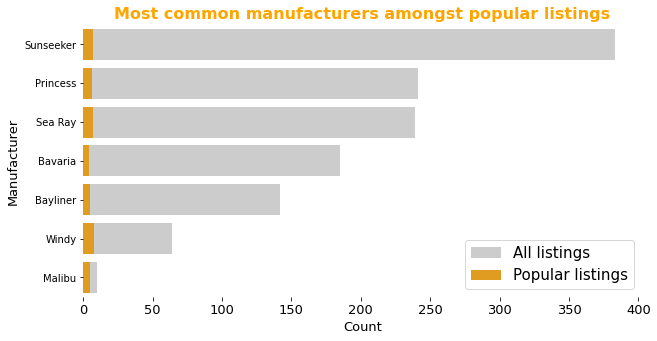

In [170]:
x1, x2 = filter_value_counts (new_df, popular_df, 'Manufacturer', 3) 
do_barplot(x1, x2, "Most common manufacturers amongst popular listings", "Manufacturer", "manufacturer")

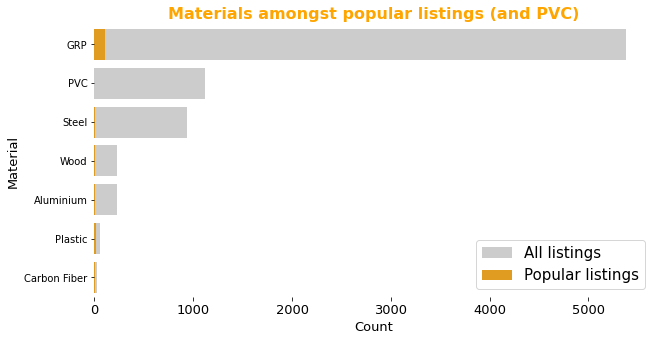

In [171]:
x1, x2 = append_value (new_df, popular_df, 'Material', {"PVC":0})
do_barplot(x1, x2, "Materials amongst popular listings (and PVC)", "Material", "material")

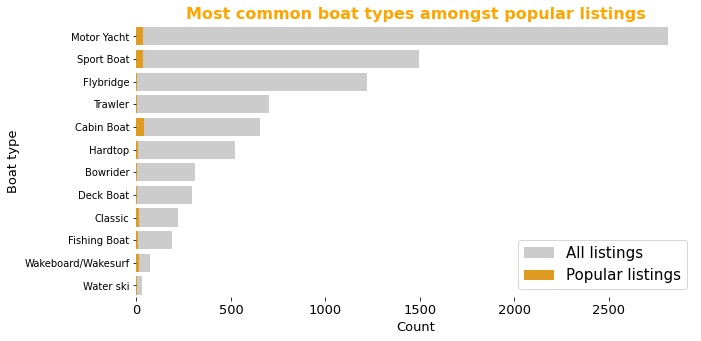

In [172]:
x1, x2 = filter_sum (new_df, popular_df, "Boat type", 3)
do_barplot(x1, x2, "Most common boat types amongst popular listings", "Boat type", "boat_type")

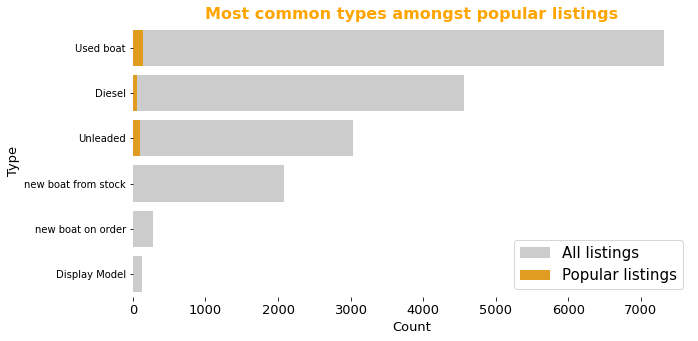

In [173]:
x1, x2 = filter_sum (new_df, popular_df, "Type", 0)
do_barplot(x1, x2, "Most common types amongst popular listings", "Type", "type")

### Country treemap

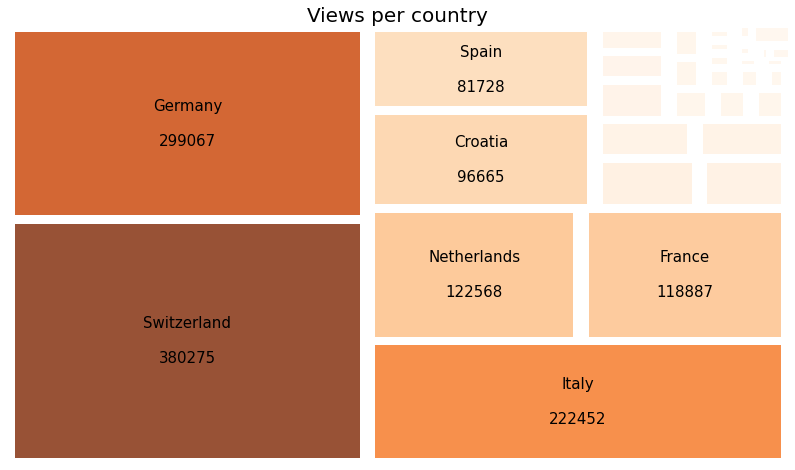

In [174]:
s = new_df.groupby("Country")['Number of views last 7 days'].agg('sum').sort_values(ascending=False)

sizes = s.values
labels = s[s>50000].index

labels = [f'{country}\n\n{int(count)}' for country, count in zip(labels, sizes)]

cmap=matplotlib.cm.Oranges
norm=matplotlib.colors.Normalize(vmin=sizes.min(),
                                 vmax=sizes.max())

colors=[cmap(norm(i)) for i in sizes]

plt.figure(figsize=(14,8))
title='Views per country'
plt.title(title, size=20)
squarify.plot(sizes, label=labels,alpha=0.8, color=colors, pad=True, 
              text_kwargs={'color':'black', 'size':15})
plt.axis('off')

plt.savefig("images/country.png", transparent=True, dpi=120)
plt.show()

The countries with the most views are all in Central Europe. Since they are all in the same continent, there is no need to use the Continent column.